# Practical Session on Conditional Autoencoder.
Prepared by: Santiago VELASCO-FORERO (https://people.cmm.minesparis.psl.eu/users/velasco/)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
LATENT_DIM=2
NUM_CLASSES=10
NUM_EPOCHS=128

In [3]:
(train_images, train_label), (test_images, test_label) = tf.keras.datasets.mnist.load_data()
train_images=np.expand_dims(train_images,axis=-1)/255.
test_images=np.expand_dims(test_images,axis=-1)/255.
input_shape=train_images.shape[1:]
print('input_shape',input_shape)
train_label=tf.one_hot(train_label,NUM_CLASSES)
print('train_label',train_label.shape)

NEXAMPLES=1000
train_images=train_images[0:NEXAMPLES]
train_label=train_label[0:NEXAMPLES,:]

test_label=tf.one_hot(test_label,NUM_CLASSES)

input_shape (28, 28, 1)
train_label (60000, 10)


In [4]:
def generate_model_enconder():
    layer0=tf.keras.layers.Input(shape=input_shape)
    layer1=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',activation='gelu')(layer0)
    layer2=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation='gelu')(layer1)
    layer3=tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(2,2), activation='gelu')(layer2)
    layer4=tf.keras.layers.GlobalAveragePooling2D()(layer3)
    layer5=tf.keras.layers.Dense(LATENT_DIM)(layer4)
    layerout=tf.keras.layers.BatchNormalization()(layer5)
    return tf.keras.Model(layer0,layerout)

In [5]:
model_encoder= generate_model_enconder()
model_encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 32)          25632     
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                             

## Questions?
- Why (which option does that) there is a reduction in tensor size from [28,28] to [13,13]?
- Where do the 4 non-trainable parameters come from?
- Why are there 66 parameters in the layer Dense?
- What does the "Global Average Pooling 2D" layer?
- Is this network invariant to translation? (shift in x and y, if the effects of the border are not considered)


In [6]:
layerDec0=tf.keras.layers.Input(shape=LATENT_DIM)
layerDec1=tf.keras.layers.Dense(49,activation='relu')(layerDec0)
layerDec2=tf.keras.layers.Reshape([7,7,1])(layerDec1)
layerDec2=tf.keras.layers.Activation('relu')(layerDec2)
layerDec3=tf.keras.layers.UpSampling2D((2, 2),interpolation='nearest')(layerDec2)
layerDec4=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(layerDec3)
layerDec5=tf.keras.layers.UpSampling2D((2, 2),interpolation='nearest')(layerDec4)
layerDec6=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(layerDec5)
layerDec7=tf.keras.layers.BatchNormalization()(layerDec6)
layerDec8=tf.keras.layers.Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid')(layerDec7)
model_decoder=tf.keras.Model(layerDec0,layerDec8)
model_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 49)                147       
                                                                 
 reshape (Reshape)           (None, 7, 7, 1)           0         
                                                                 
 activation (Activation)     (None, 7, 7, 1)           0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 1)         0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        320       
                                                           

# Questions?

- Why (which option does that) there is a inceasing in tensor size from [7,7] to [14,14]?
- Where do the 64 non-trainable parameters come from?


In [7]:
layerCondDec0A=tf.keras.layers.Input(shape=LATENT_DIM)
layerCondDec0B=tf.keras.layers.Input(shape=NUM_CLASSES)
layerCondDec0=tf.keras.layers.Concatenate()([layerCondDec0A,layerCondDec0B])
layerCondDec1=tf.keras.layers.Dense(49,activation='relu')(layerCondDec0)
layerCondDec2=tf.keras.layers.Reshape([7,7,1])(layerCondDec1)
layerCondDec2=tf.keras.layers.Activation('relu')(layerCondDec2)
layerCondDec3=tf.keras.layers.UpSampling2D((2, 2),interpolation='nearest')(layerCondDec2)
layerCondDec4=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(layerCondDec3)
layerCondDec5=tf.keras.layers.UpSampling2D((2, 2),interpolation='nearest')(layerCondDec4)
layerCondDec6=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(layerCondDec5)
layerCondDec7=tf.keras.layers.BatchNormalization()(layerCondDec6)
layerCondDec8=tf.keras.layers.Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid')(layerCondDec7)
model_conditional_decoder=tf.keras.Model([layerCondDec0A,layerCondDec0B],layerCondDec8)
model_conditional_decoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 12)                   0         ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 49)                   637       ['concatenate[0][0]']   

In [8]:
model_conditional_decoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 12)                   0         ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 49)                   637       ['concatenate[0][0]']   

## Questions?

- What is being used to condition generation in this model? (i.e, how is codified the condition?)
- Why do you think it is important to use sigmoid activation in the last layer?


In [9]:
layer_input_image=tf.keras.layers.Input(shape=input_shape)
model=tf.keras.Model(layer_input_image,model_decoder(model_encoder(layer_input_image)))
model.summary()



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 2)                 35274     
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         9876      
                                                                 
Total params: 45150 (176.37 KB)
Trainable params: 45082 (176.10 KB)
Non-trainable params: 68 (272.00 Byte)
_________________________________________________________________


In [10]:
model_encoder2= generate_model_enconder()

layer_input_condition=tf.keras.layers.Input(shape=NUM_CLASSES)

modelCond=tf.keras.Model([layer_input_image,layer_input_condition],model_conditional_decoder([model_encoder2(layer_input_image),layer_input_condition]))
modelCond.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 model_4 (Functional)        (None, 2)                    35274     ['input_5[0][0]']             
                                                                                                  
 input_7 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 model_2 (Functional)        (None, 28, 28, 1)            10366     ['model_4[0][0]',             
                                                                     'input_7[0][0]']       

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
              loss=tf.keras.losses.mean_squared_logarithmic_error,
              metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.MSE])

In [12]:
historymodel=model.fit(train_images,train_images,validation_data=(test_images,test_images),epochs=NUM_EPOCHS)

Epoch 1/128
32/32 [==============================] - 2s 62ms/step - loss: 0.1135 - binary_accuracy: 0.6297 - mean_squared_error: 0.1998 - val_loss: 0.1179 - val_binary_accuracy: 0.7949 - val_mean_squared_error: 0.1857
Epoch 2/128
32/32 [==============================] - 2s 63ms/step - loss: 0.0725 - binary_accuracy: 0.7347 - mean_squared_error: 0.1336 - val_loss: 0.0859 - val_binary_accuracy: 0.8072 - val_mean_squared_error: 0.1369
Epoch 3/128
32/32 [==============================] - 2s 63ms/step - loss: 0.0532 - binary_accuracy: 0.7649 - mean_squared_error: 0.1014 - val_loss: 0.0686 - val_binary_accuracy: 0.8072 - val_mean_squared_error: 0.1136
Epoch 4/128
32/32 [==============================] - 2s 64ms/step - loss: 0.0451 - binary_accuracy: 0.7779 - mean_squared_error: 0.0875 - val_loss: 0.0570 - val_binary_accuracy: 0.8072 - val_mean_squared_error: 0.1000
Epoch 5/128
32/32 [==============================] - 2s 63ms/step - loss: 0.0410 - binary_accuracy: 0.7851 - mean_squared_error:

In [13]:
modelCond.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
              loss=tf.keras.losses.mean_squared_logarithmic_error,
              metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.MSE])

Text(0, 0.5, 'loss')

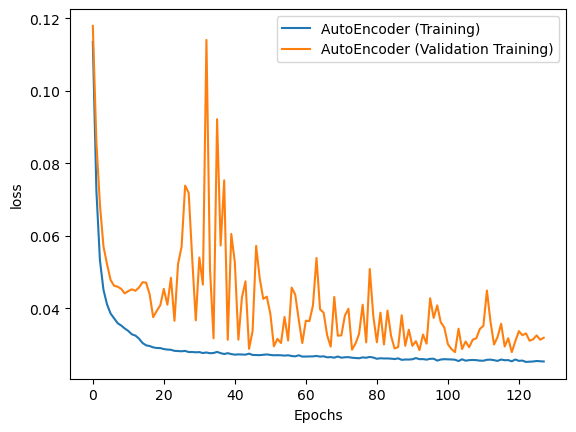

In [14]:
plt.plot(historymodel.history['loss'],label='AutoEncoder (Training)')
plt.plot(historymodel.history['val_loss'],label='AutoEncoder (Validation Training)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')

In [15]:
## Questions? (Understanding the architecture)
- From the previos curves do you think that the model overfits?
- Why do you think it is important to use sigmoid activation in the last layer?


Object `overfits` not found.
Object `layer` not found.


In [16]:
historymodelCond=modelCond.fit([train_images,train_label],train_images,validation_data=([test_images,test_label],test_images),epochs=NUM_EPOCHS)

Epoch 1/128
32/32 [==============================] - 3s 88ms/step - loss: 0.1263 - binary_accuracy: 0.5689 - mean_squared_error: 0.2087 - val_loss: 0.1249 - val_binary_accuracy: 0.7611 - val_mean_squared_error: 0.1974
Epoch 2/128
32/32 [==============================] - 3s 84ms/step - loss: 0.0813 - binary_accuracy: 0.7138 - mean_squared_error: 0.1467 - val_loss: 0.1002 - val_binary_accuracy: 0.7783 - val_mean_squared_error: 0.1573
Epoch 3/128
32/32 [==============================] - 3s 84ms/step - loss: 0.0568 - binary_accuracy: 0.7641 - mean_squared_error: 0.1068 - val_loss: 0.0744 - val_binary_accuracy: 0.8028 - val_mean_squared_error: 0.1197
Epoch 4/128
32/32 [==============================] - 3s 86ms/step - loss: 0.0473 - binary_accuracy: 0.7766 - mean_squared_error: 0.0914 - val_loss: 0.0632 - val_binary_accuracy: 0.7961 - val_mean_squared_error: 0.1044
Epoch 5/128
32/32 [==============================] - 2s 79ms/step - loss: 0.0422 - binary_accuracy: 0.7828 - mean_squared_error:

Text(0, 0.5, 'loss')

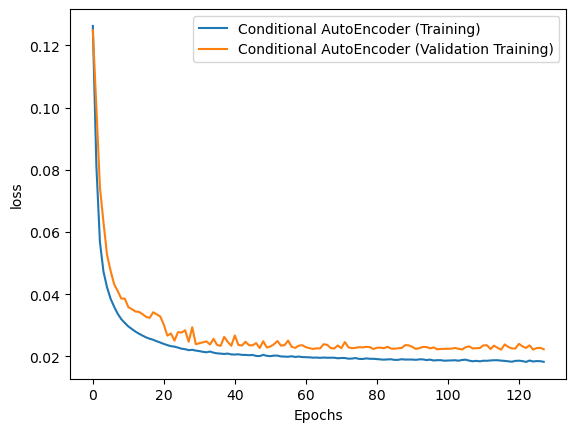

In [17]:
plt.plot(historymodelCond.history['loss'],label='Conditional AutoEncoder (Training)')
plt.plot(historymodelCond.history['val_loss'],label='Conditional AutoEncoder (Validation Training)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')

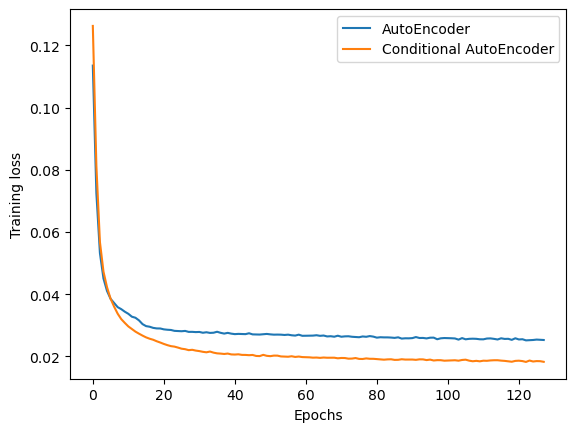

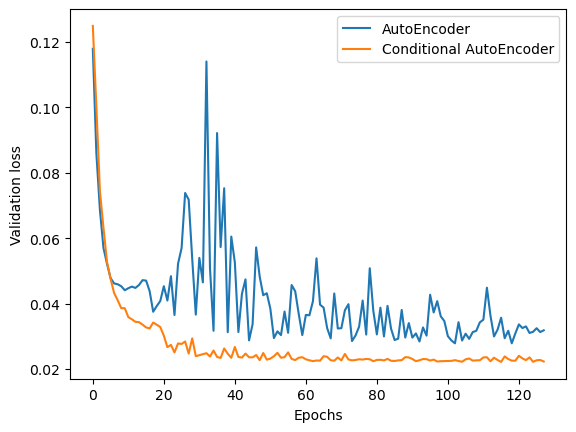

In [18]:
plt.plot(historymodel.history['loss'],label='AutoEncoder')
plt.plot(historymodelCond.history['loss'],label='Conditional AutoEncoder')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.show()

plt.plot(historymodel.history['val_loss'],label='AutoEncoder')
plt.plot(historymodelCond.history['val_loss'],label='Conditional AutoEncoder')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.show()

## Questions
- Which model perform better? why?

32/32 [==============================] - 0s 3ms/step


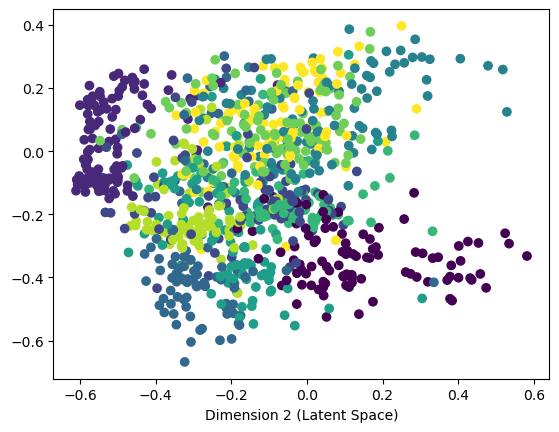

32/32 [==============================] - 0s 3ms/step


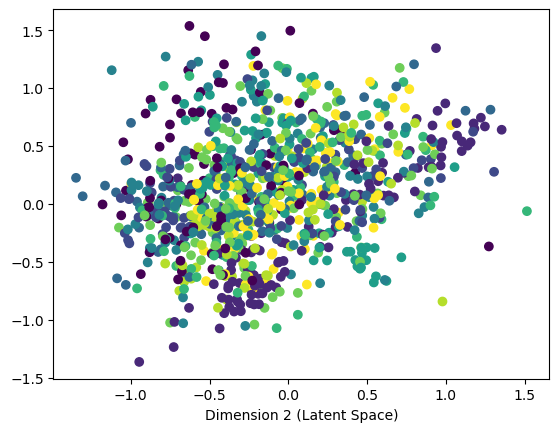

In [19]:
Z=model_encoder.predict(train_images)
plt.scatter(Z[:,0],Z[:,1],c=np.argmax(train_label,axis=1))
plt.xlabel('Dimension 1 (Latent Space)')
plt.xlabel('Dimension 2 (Latent Space)')
plt.show()

Z=model_encoder2.predict(train_images)
plt.scatter(Z[:,0],Z[:,1],c=np.argmax(train_label,axis=1))
plt.xlabel('Dimension 1 (Latent Space)')
plt.xlabel('Dimension 2 (Latent Space)')
plt.show()

## Visualizing some generated data


1/1 [==============================] - 0s 7ms/step


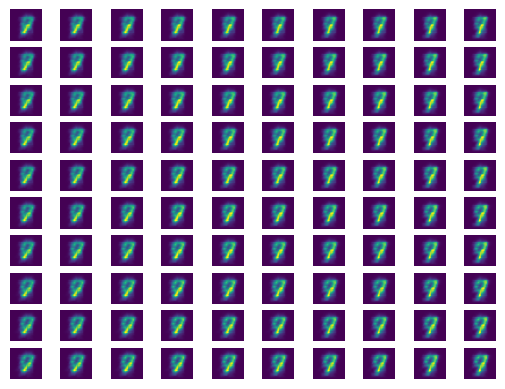

In [20]:

idx=0
for i in range(-5,5,1):
    for j in range(-5,5,1):
        idx=idx+1
        plt.subplot(10,10,idx)
        value=np.zeros([1,LATENT_DIM])
        value[0,0]=.01*i
        value[0,1]=.01*j
        I=model_decoder.predict(value)
        plt.imshow(I[0])
        plt.axis('off')
plt.show()

1/1 [==============================] - 0s 7ms/step


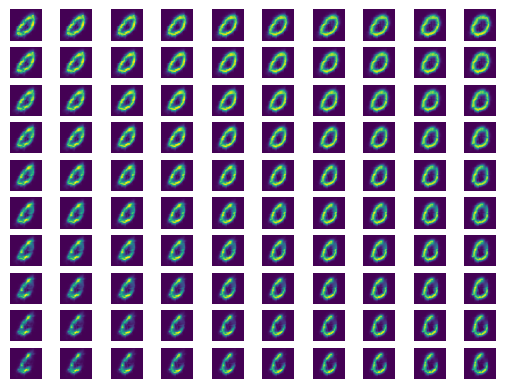

In [21]:
# Visualizing some generated data from the conditioning decoder
idx=0
for i in range(-5,5,1):
    for j in range(-5,5,1):
        idx=idx+1
        plt.subplot(10,10,idx)
        value=np.zeros([1,LATENT_DIM])
        value[0,0]=.1*i
        value[0,1]=.1*j
        condition=np.zeros([1,10])
        condition[0,0]=1
        I=model_conditional_decoder.predict([value,condition])
        plt.imshow(I[0])
        plt.axis('off')
plt.show()

1/1 [==============================] - 0s 6ms/step


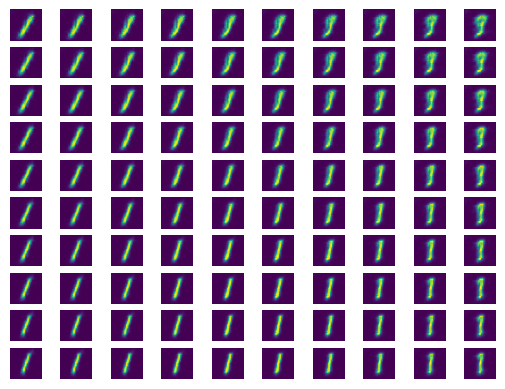

In [22]:
# Visualizing some generated data from the conditioning decoder
idx=0
for i in range(-5,5,1):
    for j in range(-5,5,1):
        idx=idx+1
        plt.subplot(10,10,idx)
        value=np.zeros([1,LATENT_DIM])
        value[0,0]=.1*i
        value[0,1]=.1*j
        condition=np.zeros([1,10])
        condition[0,1]=1
        I=model_conditional_decoder.predict([value,condition])
        plt.imshow(I[0])
        plt.axis('off')
plt.show()

## Question
- Can you use the conditional model to generate examples of eights?
